In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
from torchviz import make_dot
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import display, clear_output
import plotly.express as px
import holocron
import pandas as pd
import random
from models import *
import monai
from torch.cuda.amp import GradScaler, autocast
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select, CustomJS
from bokeh.layouts import column, row
from concurrent.futures import ThreadPoolExecutor, as_completed
import math

%matplotlib inline

c:\Users\Bartek\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bartek\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
class newDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(512,512), transform=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_size=input_size
        self.transform=transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path=self.image_files[idx]
        mask_path=self.mask_files[idx]  

        image = cv2.imread(image_path, 0)
        mask = cv2.imread(mask_path, 0)  

        image = self.image_histogram_equalization(image.astype('float32')/ image.max())
        image = image 
        mask = mask.astype('float32')/255.

        image=torch.tensor(image)
        mask=torch.tensor(mask)

        if self.transform:
            image,mask=self.augment_image(image,mask)
        
        return image, mask
    
    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image, mask):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        mask_np = mask.reshape(shape).numpy()
        augmented = self.transform(image = image_np,mask = mask_np)
        augmented_image , augmented_mask = augmented['image'],augmented['mask']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_mask = augmented_mask.reshape(augmented_mask.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
        
        return augmented_image,augmented_mask

class newDatasetPatches(Dataset):
    def __init__(self, image_files, mask_files, patch_size=512, patch_overlap=0.2, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.patch_size = patch_size
        self.patch_overlap = patch_overlap
        self.patch_indices = self.calculate_patch_indices()

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        img_path, mask_path, (y, x) = self.patch_indices[idx]
        patch_image, patch_mask = self.load_patch(img_path, mask_path, y, x)

        patch_image = self.image_histogram_equalization(patch_image.astype('float32')/ patch_image.max())
        patch_image = patch_image 
        patch_mask = patch_mask.astype('float32') / 255.
        

        patch_image = torch.tensor(patch_image, dtype=torch.float32)
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32)

        if self.transform:
            patch_image, patch_mask = self.augment_image(patch_image, patch_mask)

        return patch_image, patch_mask

    def calculate_patch_indices(self):
        with ThreadPoolExecutor() as executor:
            tasks = [executor.submit(self.calculate_patch_indices_for_image, img_path, mask_path)
                     for img_path, mask_path in zip(self.image_files, self.mask_files)]

            patch_indices = []
            for future in as_completed(tasks):
                patch_indices.extend(future.result())

        return patch_indices
    
    def calculate_patch_indices_for_image(self, img_path, mask_path):
        def calculate_dynamic_step(img_dim, patch_dim, overlap_fraction):
            overlap = int(patch_dim * overlap_fraction)
            step = patch_dim - overlap
            num_patches = math.ceil((img_dim - overlap) / step)
            step = (img_dim - patch_dim) / (num_patches - 1) if num_patches > 1 else 0
            return step, num_patches
        
        image = cv2.imread(img_path, 0)
        step_h, num_patches_h = calculate_dynamic_step(image.shape[0], self.patch_size, self.patch_overlap)
        step_w, num_patches_w = calculate_dynamic_step(image.shape[1], self.patch_size, self.patch_overlap)

        patch_indices = []
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step_h)
                x = int(j * step_w)
                patch_indices.append((img_path, mask_path, (y, x)))
        
        return patch_indices


    def load_patch(self, img_path, mask_path, y, x):
        image = cv2.imread(img_path, 0)
        mask = cv2.imread(mask_path, 0)
        patch_img = image[y:y + self.patch_size, x:x + self.patch_size]
        patch_mask = mask[y:y + self.patch_size, x:x + self.patch_size]

        return patch_img, patch_mask
    
        
    """def reconstruct_image_from_patches(self, patches, original_shape):
        reconstructed_image = np.zeros(original_shape, dtype=patches[0][0].dtype)

        step = int(self.patch_size * (1 - self.patch_overlap))
        num_patches_h = math.ceil((original_shape[0] - self.patch_size) / step + 1)
        num_patches_w = math.ceil((original_shape[1] - self.patch_size) / step + 1)

        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step)
                x = int(j * step)
                patch_img, _ = patches[i * num_patches_w + j] 
                reconstructed_image[y:y + self.patch_size, x:x + self.patch_size] = patch_img

        return reconstructed_image"""

    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image, mask):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        mask_np = mask.reshape(shape).numpy()
        augmented = self.transform(image = image_np,mask = mask_np)
        augmented_image , augmented_mask = augmented['image'],augmented['mask']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_mask = augmented_mask.reshape(augmented_mask.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
        
        return augmented_image,augmented_mask

    def calculate_num_patches(self, image_height, image_width):
        step_w = int(self.patch_size * (1-self.patch_overlap))
        step_h = int(self.patch_size * (1-self.patch_overlap))

        num_patches_w = math.ceil((image_width - self.patch_size) / step_w + 1)
        num_patches_h = math.ceil((image_height - self.patch_size) / step_h + 1)

        return num_patches_w * num_patches_h



class SegmentationPerformance:
    def __init__(self, num_samples=5, device='cuda'):
        self.metrics_sum = {'Precision': 0, 'Recall': 0, 'Accuracy': 0, 'Dice Coefficient': 0, 'IoU': 0}
        self.count = 0
        self.total_loss = 0.0
        self.total_loss1 = 0.0
        self.saved_samples = []
        self.num_samples = num_samples
        self.device = device
        self.surface_dice = 0.0

    def precision_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_pred = torch.sum(pred_mask)
        precision = intersect.float() / total_pixel_pred.float() if total_pixel_pred != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return precision.item()

    def recall_score_(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_pixel_truth = torch.sum(groundtruth_mask)
        recall = intersect.float() / total_pixel_truth.float() if total_pixel_truth != 0 else torch.tensor(0.0, device=groundtruth_mask.device)
        return recall.item()

    def accuracy(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        xor = torch.sum(groundtruth_mask == pred_mask)
        acc = xor.float() / (union + xor - intersect).float() if (union + xor - intersect) != 0 else torch.tensor(0.0, device=self.device)
        return acc.item()

    def dice_coef(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
        dice = (2 * intersect).float() / total_sum.float() if total_sum != 0 else torch.tensor(0.0, device=self.device)
        return dice.item()

    def iou(self, groundtruth_mask, pred_mask):
        intersect = torch.sum(pred_mask * groundtruth_mask)
        union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
        iou = intersect.float() / union.float() if union != 0 else torch.tensor(0.0, device=self.device)
        return iou.item()

    def update_metrics_and_save_sample(self, groundtruth_mask, pred_mask, loss=None,loss1=None, image=None, gt_mask=None, pred_mask_sample=None):
        self.metrics_sum['Precision'] += self.precision_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Recall'] += self.recall_score_(groundtruth_mask, pred_mask)
        self.metrics_sum['Accuracy'] += self.accuracy(groundtruth_mask, pred_mask)
        self.metrics_sum['Dice Coefficient'] += self.dice_coef(groundtruth_mask, pred_mask)
        self.metrics_sum['IoU'] += self.iou(groundtruth_mask, pred_mask)
        if loss is not None:
            self.total_loss += loss.item()

        if loss1 is not None:
            self.total_loss1 += loss1.item()

        if image is not None:
            # Convert to CPU for plotting
            self.saved_samples.append((image.cpu().numpy(), gt_mask.cpu().numpy(), pred_mask_sample.cpu().numpy()))

        self.count += 1

    def get_average_metrics(self):
        average_metrics = {metric: value / self.count for metric, value in self.metrics_sum.items()}
        average_metrics['Average Loss'] = self.total_loss / self.count if self.count != 0 else 0
        average_metrics['Average Loss1'] = self.total_loss1 / self.count if self.count != 0 else 0
        return average_metrics

    def report(self):
        metrics = self.get_average_metrics()
        return pd.DataFrame([metrics])
    
    def plot_saved_samples(self, figsize=(15, 15)):
        if not self.saved_samples:
            print("No samples saved for plotting.")
            return

        plt.figure(figsize=figsize)

        for i, (image, groundtruth_mask, predicted_mask) in enumerate(self.saved_samples):
            if image.ndim == 3:
                if image.shape[0] == 3:  
                    image = image.transpose(1, 2, 0)
                elif image.shape[0] == 1:  
                    image = image.squeeze(0)  #

            image = (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

            plt.subplot(self.num_samples, 3, i * 3 + 1)
            plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
            plt.title('Image')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 2)
            plt.imshow(groundtruth_mask.squeeze(), cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 3)
            plt.imshow(predicted_mask.squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [58]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\train"
datasets = ["kidney_1_dense", "kidney_1_voi", "kidney_2", "kidney_3_sparse"]

image_files = []
labels_files = []
for dataset in datasets:
    images_path = os.path.join(base_path,dataset,"images")
    label_path = os.path.join(base_path,dataset,"labels")

    image_files.extend(sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')]))
    labels_files.extend(sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')]))

In [59]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, labels_files, test_size=0.2, random_state=42)

train_image_files[:5]

['C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_2\\images\\0126.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_3_sparse\\images\\0208.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_voi\\images\\1033.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_voi\\images\\0398.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_3_sparse\\images\\0628.tif']

In [70]:
transform = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
])

val_dataset = newDataset(val_image_files[:50], val_mask_files[:50], transform=transform)
val_dataset_patches = newDatasetPatches(val_image_files[:50], val_mask_files[:50], transform=transform)

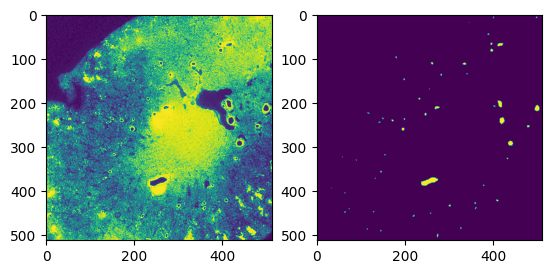

In [71]:
plt.subplot(1,2,1)
plt.imshow(val_dataset_patches[5][0].numpy())
plt.subplot(1,2,2)
plt.imshow(val_dataset_patches[5][1].numpy())


In [72]:
#train_dataloader= DataLoader(train_dataset,batch_size=6,shuffle=True)
batch_size = 2
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False, drop_last=True)
val_dataloader_patches = DataLoader(val_dataset_patches,batch_size=batch_size,shuffle=False, drop_last=True)

In [ ]:
"""
###############################################################


model = smp.UnetPlusPlus(
    encoder_name='timm-resnest50d',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_resnet50d_50epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='dpn92',
    encoder_weights='imagenet+5k',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_dpn92_50epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-regnetx_120',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_regnetx120_45epoch.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-res2net50_26w_8s',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['best_model_res2net50_26w_8s_50epoch.pth'] = model


model = monai.networks.nets.SwinUNETR(
    img_size=(512,512), 
    in_channels=1, 
    out_channels=1, 
    use_checkpoint=True, 
    spatial_dims=2,
    depths=(4,4,6,6),
    num_heads=(4,8,16,32),
    feature_size=48,
    drop_rate=0.05,            
    attn_drop_rate=0.05

).to(device)

models['best_model_swissunetr.pth'] = model



model = monai.networks.nets.UNETR(
    img_size=512, 
    in_channels=1, 
    out_channels=1, 
    hidden_size=1024,
    feature_size=32,
    num_heads=32,
    dropout_rate=0.05,            
    spatial_dims=2

).to(device)

models['best_model_unetr.pth'] = model


#OLD
model = MultiResUnet(
    input_channels=1,
	num_classes=0
    ).to(device)

models['best_model_multiresunet.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-resnest26d',
    encoder_weights='imagenet',
    in_channels=1
).to(device)

models['best_model_resnet26d_150epoch.pth'] = model

#Obraz RGB potrzebny
#model = TransMUNet(
#    n_classes=3
#).to(device)
#
#models['best_model_transmunet.pth'] = model

#nie moge sobie przypomniec inicjalizacji modelu
#model = holocron.models.segmentation.unetpp(
#    in_channels=1,
#    num_classes=1
#).to(device)

#models['best_model_unetpp.pth'] = model


model = holocron.models.segmentation.unet3p(
    in_channels=1,
    num_classes=1
).to(device)

models['best_model_unet3p.pth'] = model

model = R2AttU_Net(img_ch=1,output_ch=1).to(device)

models['best_modelR2AttU_Net.pth'] = model
"""

In [65]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}


model = smp.UnetPlusPlus(
        encoder_name='resnext101_32x16d',
        encoder_weights=None,
        decoder_attention_type="scse",
        in_channels=1
    ).to(device)

models['/kaggle/input/models-full/best_model.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-resnest101e',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['/kaggle/input/models-full/best_model_full_resnest101e.pth'] = model

model = monai.networks.nets.SwinUNETR(
    img_size=(512,512),
    in_channels=1,
    out_channels=1,
    use_checkpoint=True,
    spatial_dims=2,
    depths=(10,8,8,6),
    num_heads=(6,12,24,48),
    feature_size=60,
    drop_rate=0.05,
    attn_drop_rate=0.05
).to(device)

models['/kaggle/input/models-full/best_model_full_swinunetr.pth'] = model

model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

models['/kaggle/input/models-full/best_model_patches_resnest200e.pth'] = model

#swin
model = monai.networks.nets.SwinUNETR(
    img_size=(512,512), 
    in_channels=1, 
    out_channels=1, 
    use_checkpoint=True, 
    spatial_dims=2,
    depths=(4,4,6,8),
    num_heads=(4,8,16,32),
    feature_size=48,
    drop_rate=0.05,            
    attn_drop_rate=0.05
).to(device)

models['/kaggle/input/models_new/pytorch/default/1/SwinUNETR.pth'] = model

#maxvit
model = smp.UnetPlusPlus(
    encoder_name='tu-maxvit_base_tf_512',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)
models[f'/kaggle/input/models_new/pytorch/default/1/{model.name}.pth'] = model

#deeplabv3 
model = smp.DeepLabV3Plus(
        encoder_name='tu-seresnextaa101d_32x8d',
        encoder_weights='imagenet',
        in_channels=1,
        decoder_atrous_rates=(6,12,24),
        decoder_channels=512
    )
models['/kaggle/input/models_new/pytorch/default/1/DeepLabV3Plus_seresnextaa101d_32x8d.pth'] = model

In [81]:
def eval_model_perf(model, criterion, criterion1, idxs, patch=False):
    performance_evaluator = SegmentationPerformance()
    print(patch)
    pbar = tqdm.tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
    patch = patchImage()
    transform = A.Compose([
        A.Resize(512,512, interpolation=cv2.INTER_NEAREST)
    ])

    transform_back = A.Compose([
        A.Resize(768,768, interpolation=cv2.INTER_NEAREST)
    ])
    rles = {}
       
    with torch.no_grad():
        for n,(images, masks, path) in enumerate(val_dataloader_patches):  
            tmp = patch.extract_patches(images[0][0])
            patches = []
            for i in tmp:
                patches.append(transform(image=i)['image'])

            patches = np.array(patches)
            patches = torch.tensor(patches, dtype=torch.float32)
            b, h, w, c = (len(patches), *patches[0].shape, 1)
            patches = patches.reshape(b,c,h,w).to(device)

            masks = masks.reshape(b,c,h,w).to(device)
            
            with autocast():
                preds = model(patches)

            preds = preds.reshape(b,h,w)
            preds_rs = []
            for i in preds:
                preds_rs.append(transform_back(image=i.cpu().numpy())['image'])

            img = patch.reconstruct_from_patches(preds_rs, images[0][0].shape)
            img = (img > 0.1).astype(float)
            rle = rle_encode(img)

            rles[path] = rle

            with autocast():
                loss = criterion(img, masks)
                loss1 = criterion1(img, masks)

            if n in idxs:
                tmp = random.choices(range(batch_size))
                performance_evaluator.update_metrics_and_save_sample(masks, img, loss, loss1, images[tmp], masks[tmp], img[tmp])
            else:
                performance_evaluator.update_metrics_and_save_sample(masks, img, loss, loss1)

    return performance_evaluator

def plot_model_comparisons(perfs, model_names, figsize=(10, 20)):
    num_models = len(model_names)

    if not perfs:
        print("No performance data available for plotting.")
        return

    num_samples = len(perfs[0].saved_samples)
    plt.figure(figsize=figsize)

    for i in range(num_samples):
        image, ground_truth, _ = perfs[0].saved_samples[i]

        # Plot original image
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('Original Image', fontsize=10)
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 2)
        plt.imshow(ground_truth.squeeze(), cmap='gray')
        plt.title('Ground Truth', fontsize=10)
        plt.axis('off')

        # Plot predictions from each model
        for j, perf in enumerate(perfs):
            _, _, prediction = perf.saved_samples[i]
            plt.subplot(num_samples, num_models + 2, i * (num_models + 2) + 3 + j)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title(f'Model {model_names[j]} Prediction', fontsize=5)
            plt.axis('off')

    plt.tight_layout()
    plt.show()    

In [82]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\models"
criterion = torch.nn.BCEWithLogitsLoss()
criterion = smp.losses.TverskyLoss(
        mode='binary',         # Since it's binary segmentation
        from_logits=True,       # Use this if your model outputs logits
        alpha=0.3,              # Penalize false positives less
        beta=0.7,               # Penalize false negatives more
        smooth=1e-6             # Small smoothness constant for numerical stability
    )
perfs = []
perfs_df = pd.DataFrame()
idxs = [0, 5, 10, 15, 20, 25]#np.random.choice(range(int(len(val_image_files)/batch_size)-1), size=10, replace=False)

for model_name in list(models.keys()):
    print(model_name)
    model = models[model_name]

    state_dict = torch.load(os.path.join(base_path,model_name))

    if 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    try:
        model.load_state_dict(state_dict)
    except:
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        
    model.eval()

    perf = eval_model_perf(model, criterion, idxs, patch = True if 'patches' in model_name else False)
    perfs.append(perf)
    tmp = perf.report()
    tmp.insert(loc=0, column='model', value=model_name)

    tmp['param_cnt'] = sum(p.numel() for p in model.parameters())
    
    perfs_df = pd.concat([perfs_df, tmp])

    torch.cuda.empty_cache()
    


best_model_full_resnest101e.pth
False
best_model_full_swinunetr.pth
False
best_model_patches_resnest200e.pth
True


In [83]:
perfs_df

,model,Precision,Recall,Accuracy,Dice Coefficient,IoU,Average Loss,param_cnt
0,best_model_full_resnest101e.pth,0.958724,0.762447,0.998520,0.840331,0.737337,NaN,75435548
0,best_model_full_swinunetr.pth,0.944382,0.888557,0.999147,0.915018,0.845276,0.002412,56001925
0,best_model_patches_resnest200e.pth,0.901484,0.820373,0.999219,0.852946,0.794393,0.002137,97362076


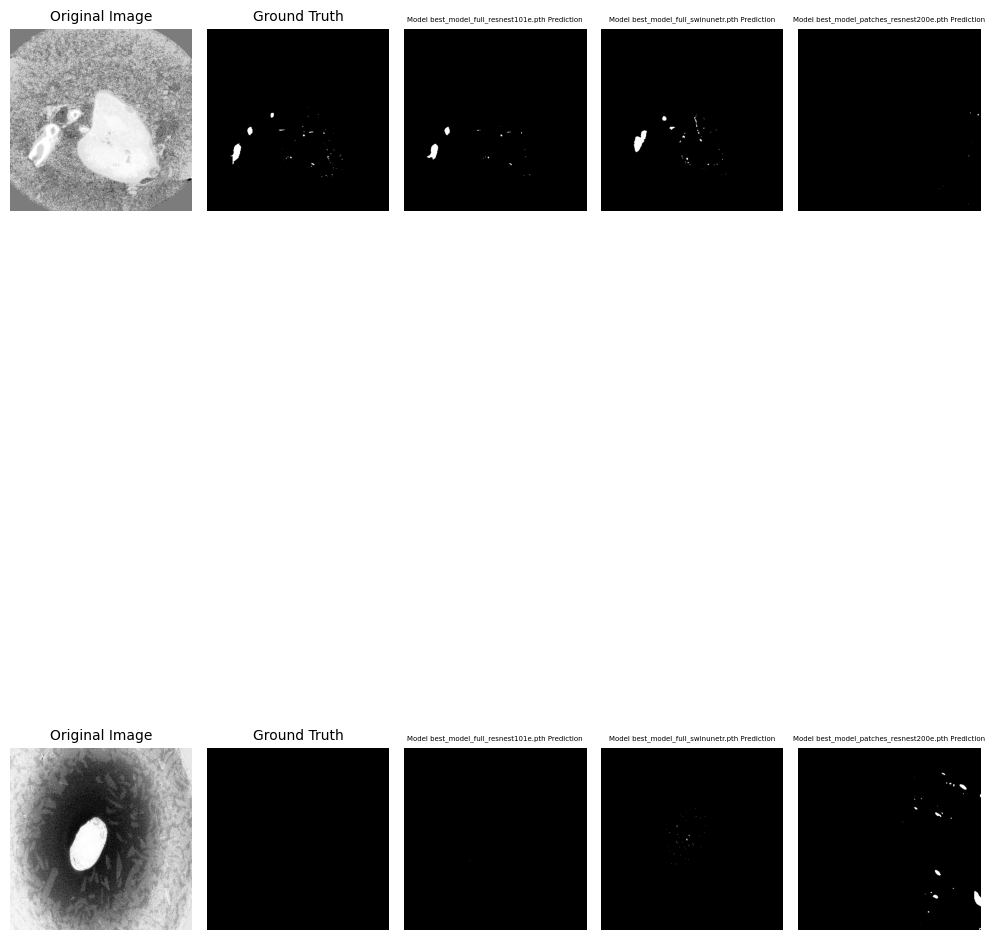

In [84]:
plot_model_comparisons(perfs, list(models.keys()))

In [18]:
def create_interactive_plot(perfs, model_names):
    num_samples = len(perfs[model_names[0]])

    sample_layouts = []
    sample_sources = [] 

    for n in range(num_samples):
        image, mask, prediction, difference = perfs[model_names[0]][n]
        source = ColumnDataSource(data={'image': [image], 'mask': [mask],
                                        'prediction': [prediction], 'diff': [difference]})
        sample_sources.append(source)

        p_image = figure(width=500, height=500, title=f"Image {n+1}")
        p_image.image(image='image', x=0, y=0, dw=10, dh=10, source=source)
        p_image.axis.visible = False

        p_mask = figure(width=500, height=500, title=f"Mask {n+1}", x_range=p_image.x_range, y_range=p_image.y_range)
        p_mask.image(image='mask', x=0, y=0, dw=10, dh=10, source=source)
        p_mask.axis.visible = False

        p_prediction = figure(width=500, height=500, title=f"Prediction {n+1}", x_range=p_image.x_range, y_range=p_image.y_range)
        p_prediction.image(image='prediction', x=0, y=0, dw=10, dh=10, source=source)
        p_prediction.axis.visible = False

        p_diff = figure(width=500, height=500, title=f"Diff {n+1}", x_range=p_image.x_range, y_range=p_image.y_range)
        p_diff.image(image='diff', x=0, y=0, dw=10, dh=10, source=source)
        p_diff.axis.visible = False

        sample_layouts.append(row(p_image, p_mask, p_prediction, p_diff))

    select = Select(title="Select Model", value=model_names[0], options=model_names)

    code = """
    var f = cb_obj.value;
    for (var n = 0; n < num_samples; n++) {
        var models = perfs[f][n];
        var current_source = sample_sources[n];
        current_source.data['image'] = [models[0]];
        current_source.data['mask'] = [models[1]];
        current_source.data['prediction'] = [models[2]];
        current_source.data['diff'] = [models[3]];
        current_source.change.emit();
    }
    """
    callback = CustomJS(args={'sample_sources': sample_sources, 'select': select, 'perfs': perfs, 'num_samples': num_samples}, code=code)
    select.js_on_change('value', callback)

    final_layout = column(select, *sample_layouts)
    return final_layout

In [ ]:
model_names = list(models.keys())

In [38]:
serialized_perfs = {}

for model_idx, model in enumerate(perfs):
    model_name = model_names[model_idx]
    serialized_perfs[model_name] = []
    for image, ground_truth, prediction in model.saved_samples:
        image = image.squeeze()
        ground_truth = ground_truth.squeeze()
        prediction = prediction.squeeze()
        if np.max(image) > 1.0:
            image = image / 255.0
        serialized_perfs[model_name].append((image,ground_truth,prediction,abs(ground_truth - prediction)>0.5))
        
lay = create_interactive_plot(serialized_perfs, model_names)
#show(lay)
from bokeh.plotting import figure, output_file, save
output_file("interactive.html")
save(lay)

'c:\\Users\\Bartek\\Desktop\\mgr\\interactive.html'

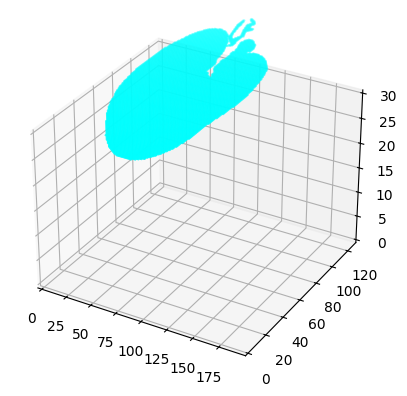

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
import os
import matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\Bartek\\Desktop\\mgr\\ffmpeg-master-latest-win64-gpl\\bin\\ffmpeg.exe'

import glob
import os

def process_mask_file(mask_file_path, blur_kernel):
    img = cv.imread(mask_file_path, cv.IMREAD_GRAYSCALE)
    blur = cv.GaussianBlur(img, blur_kernel, 0)
    _, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    largest_contour = contours[0]

    mask = np.zeros_like(thresh)
    cv.drawContours(mask, [largest_contour], -1, (255), -1)
    mask = cv2.resize(mask, (128, 196))
    return mask


# Step 1: Read the Images
image_files = sorted(glob.glob('C:/Users/Bartek/Desktop/mgr/train/kidney_1_dense/images/*.tif'))[250:1000:25]
images = [process_mask_file(file, (25,25)) for file in image_files]

# Step 2: Create a 3D Volume
volume = np.stack(images, axis=-1)

# Step 3: Visualize the 3D Volume (setup)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 4: Create an Animation
def animate(i):
    #ax.cla()  # Clear the current axes
    ax.set_xlim([0, volume.shape[0]])
    ax.set_ylim([0, volume.shape[1]])
    ax.set_zlim([0, volume.shape[2]])

    # Convert the current slice to a set of points and plot them
    y, x = np.where(volume[:, :, i] > 0)  # Get points where the mask is present
    z = np.full_like(x, i)  # Z coordinates are all 'i' for the current slice
    ax.scatter(x, y, z, c='cyan', marker='.', s=1)  # Plot points

ani = animation.FuncAnimation(fig, animate, frames=volume.shape[2], interval=100)

# Step 5: Save the Animation
ani.save('3d_volume_buildup.mp4', writer='ffmpeg', fps=2)

plt.show()



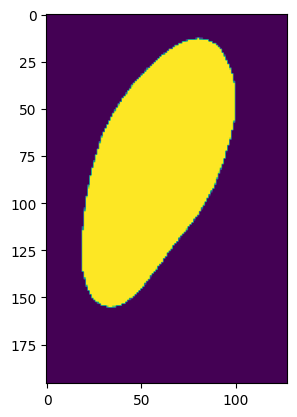

In [19]:
plt.imshow(images[2])

In [7]:
images

[]